In [15]:
#kaggle/input/cat-and-dog/

import torch, os
from torch import nn
import numpy as np
import warnings 
# Filter Warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt 

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

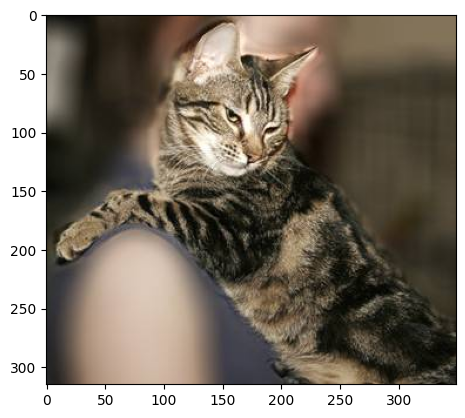

In [17]:
from PIL import Image
image = Image.open('/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.1023.jpg')
plt.imshow(np.asarray(image))

In [18]:
np.asarray(image).shape

(315, 349, 3)

## 注意torchvision transforms
https://pytorch.org/vision/stable/transforms.html#supported-input-types-and-conventions

會把原本的(H, W, Channel)變成(Channel, H, W)

In [19]:
IMG_WIDTH = 224 
IMG_HEIGHT = 224 
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
from torchvision import transforms
transform =  transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), #前面有resize了
    transforms.RandomResizedCrop(IMG_WIDTH),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

img_transformed = transform(image)
img_transformed.shape

torch.Size([3, 224, 224])

In [20]:
#base_dir = r'C:\Users\leonjye\Documents\DeepLearning\DogAndCat\dataset'
PATH_TRAIN_CAT = '/kaggle/input/cat-and-dog/training_set/training_set/cats'
PATH_TRAIN_DOG = '/kaggle/input/cat-and-dog/training_set/training_set/dogs'
PATH_TEST_CAT = '/kaggle/input/cat-and-dog/test_set/test_set/cats'
PATH_TEST_DOG = '/kaggle/input/cat-and-dog/test_set/test_set/dogs' 
 
DOG = 0
CAT = 1


NR_PIX = IMG_HEIGHT * IMG_WIDTH
NR_CHANELS = 3 # 全彩RGB
NR_FEATURES = NR_PIX * NR_CHANELS # 輸入的特徵值就是所有pixel乘上RGB

In [21]:
import pandas as pd
import glob, os

train_df = pd.DataFrame(columns=['image_files', 'labels'])
train_cat_list = glob.glob(os.path.join(PATH_TRAIN_CAT,'*.jpg'))
train_dog_list = glob.glob(os.path.join(PATH_TRAIN_DOG,'*.jpg'))
train_df['image_files'] = train_cat_list + train_dog_list
train_df['labels'] = ([CAT]*len(train_cat_list)) + ([DOG]*len(train_dog_list))
pd.set_option('max_colwidth', 400)
#train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

,image_files,labels
0,/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.3498.jpg,1
1,/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.891.jpg,1
2,/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.2842.jpg,1
3,/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.1.jpg,1
4,/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.115.jpg,1
...,...,...
8000,/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.322.jpg,0
8001,/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.2693.jpg,0
8002,/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.3865.jpg,0
8003,/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.1783.jpg,0


In [22]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])

In [23]:
class CatDog_dataset:
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = torch.FloatTensor(labels).view(-1, 1)
        self.transform = transform
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        return img, label

In [24]:
train_dataset = CatDog_dataset(train['image_files'].tolist(), train['labels'].tolist(), transform)
val_dataset = CatDog_dataset(val['image_files'].tolist(), val['labels'].tolist(), transform)
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [25]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution 1,input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) 
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) 
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(32*54*54, 1) 
    
    def forward(self, x):
        # Convolution 1, input_shape=(3,224,224)
        out = self.cnn1(x) #output_shape=(16,220,220)
        out = self.relu(out)
        out = self.maxpool(out) #output_shape=(16,110,110)
        # Convolution 2 
        out = self.cnn2(out) #output_shape=(32,108,108)
        out = self.relu(out)
        out = self.maxpool(out) #output_shape=(32,54,54)
        out = torch.flatten(out, start_dim=1) #拉平
        #out = out.view(1, -1) 
        # Linear function (readout)
        # Fully connected,#input_shape=(32*54*54)
        out = self.fc(out)
        return out

In [26]:
# Create CNN Model
class CNN_Model2(nn.Module):
    def __init__(self):
        super().__init__()
        #input_shape=(3,224,224)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=100, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=200, out_channels=400, kernel_size=3)
        self.mpool = nn.MaxPool2d(kernel_size=3)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(400*7*7,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,1)
        
    def forward(self,x):
        x = self.mpool( self.relu(self.conv1(x)) ) #conv1 output_shape=(100,220,220), maxpool output_shape=(100,73, 73)
        x = self.mpool( self.relu(self.conv2(x)) ) #conv2 output_shape=(200,38,38), maxpool output_shape=(200, 23, 23)
        x = self.mpool( self.relu(self.conv3(x)) ) #conv2 output_shape=(400,64,64), maxpool output_shape=(400,7, 7)
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x) 
        x = self.linear2(x)
        x = self.linear3(x)
        return x


In [27]:
## train & validation
epochs = 20
def train(model):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    loss_function = nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)


    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        train_loss = 0
        corrects = 0
        for i, (datas, labels) in enumerate(train_loader):
            datas = datas.to(device)
            labels = labels.to(device)
            outputs = model(datas)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.sigmoid(outputs).round().cpu().detach().numpy()
            corrects += (predicted == labels.cpu().detach().numpy()).sum()      
        train_losses.append(train_loss/len(train_dataset))
        train_accuracies.append(corrects*100/len(train_dataset))
        print(f'Epoch:{epoch}, train_accuracy:{train_accuracies[-1]}%, train_losses:{train_losses[-1]}', end='.')
        with torch.no_grad():
            val_loss = 0
            corrects = 0
            for i, (datas, labels) in enumerate(val_loader):
                datas = datas.to(device)
                labels = labels.to(device)
                outputs = model(datas)
                loss = loss_function(outputs, labels)

                val_loss += loss.item()
                predicted = torch.sigmoid(outputs).round().cpu().detach().numpy()
                corrects += (predicted == labels.cpu().detach().numpy()).sum()
            val_losses.append(val_loss/len(val_dataset))
            val_accuracies.append(corrects*100/len(val_dataset))
            print(f', val_accuracy:{val_accuracies[-1]}%, val_losses:{val_losses[-1]}')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [28]:
model = CNN_Model()
model.to(device)
train_losses, train_accuracies, val_losses, val_accuracies =  train(model)

Epoch:0, train_accuracy:56.18363522798251%, train_losses:0.6773692866104384., val_accuracy:60.836976889444095%, val_losses:0.6578076068942507
Epoch:1, train_accuracy:59.80637101811368%, train_losses:0.6577813980506406., val_accuracy:60.961898813241724%, val_losses:0.6635678855424222
Epoch:2, train_accuracy:61.18051217988757%, train_losses:0.6503385318435035., val_accuracy:61.7738913179263%, val_losses:0.6415490573975982
Epoch:3, train_accuracy:63.47595252966896%, train_losses:0.6364466964565613., val_accuracy:63.210493441599%, val_losses:0.6335786680070257
Epoch:4, train_accuracy:64.49094316052467%, train_losses:0.6291656271135114., val_accuracy:64.58463460337289%, val_losses:0.624460609907809
Epoch:5, train_accuracy:65.66208619612742%, train_losses:0.6185974990629093., val_accuracy:62.46096189881324%, val_losses:0.6368985792609172
Epoch:6, train_accuracy:65.91193004372268%, train_losses:0.6166717804721711., val_accuracy:66.89569019362898%, val_losses:0.6145759024968526
Epoch:7, train_

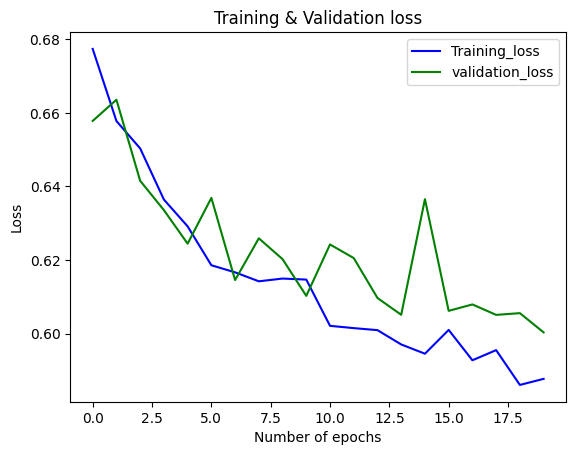

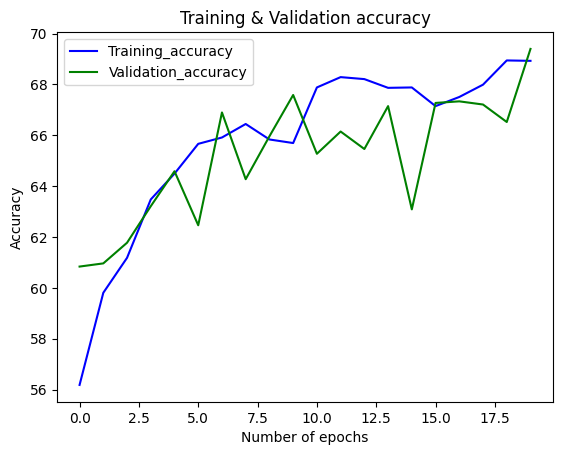

In [29]:
# visualization
plt.plot(range(epochs), train_losses, 'b-', label='Training_loss')
plt.plot(range(epochs), val_losses, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(epochs), train_accuracies, 'b-', label='Training_accuracy')
plt.plot(range(epochs), val_accuracies, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
model2 = CNN_Model2()
model2.to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train(model2)

Epoch:0, train_accuracy:51.155527795128044%, train_losses:0.6985602361719583., val_accuracy:59.21299188007495%, val_losses:0.6760837809880177
Epoch:1, train_accuracy:60.63397876327296%, train_losses:0.6590860616706595., val_accuracy:60.77451592754528%, val_losses:0.6457744934348894
Epoch:2, train_accuracy:64.80324797001875%, train_losses:0.6278272065648729., val_accuracy:65.64647095565272%, val_losses:0.6277375944996535
Epoch:3, train_accuracy:68.3322923173017%, train_losses:0.5982630771074646., val_accuracy:65.02186133666459%, val_losses:0.6211175293121243
Epoch:4, train_accuracy:68.50405996252343%, train_losses:0.5922434064166983., val_accuracy:67.39537788881948%, val_losses:0.6070570793842838
Epoch:5, train_accuracy:71.12742036227358%, train_losses:0.5633829696561157., val_accuracy:73.01686445971268%, val_losses:0.558286465532254
Epoch:6, train_accuracy:71.75202998126171%, train_losses:0.558305577327876., val_accuracy:66.9581511555278%, val_losses:0.6043635171179024
Epoch:7, train_a

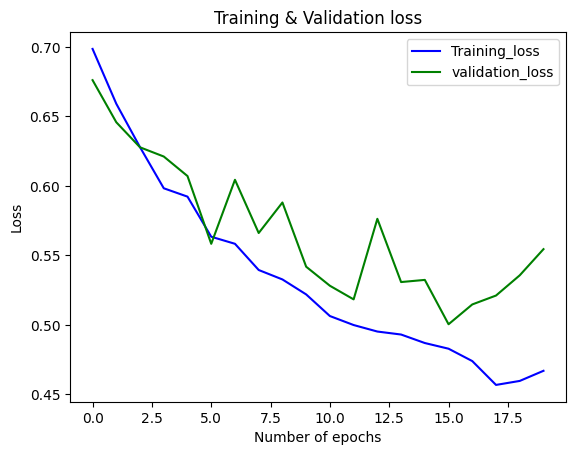

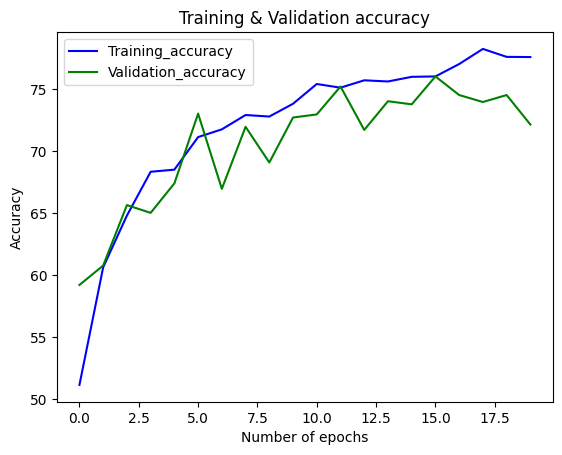

In [31]:
# visualization
plt.plot(range(epochs), train_losses, 'b-', label='Training_loss')
plt.plot(range(epochs), val_losses, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(epochs), train_accuracies, 'b-', label='Training_accuracy')
plt.plot(range(epochs), val_accuracies, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()